In [1]:
%matplotlib inline

import pandas as pd
from matplotlib import pyplot as plt
from seaborn import distplot
from seaborn import barplot
from seaborn import lmplot
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

### Объединим файлы в один, используя только все колонки кроме "event_time".
### Рассчитаем статистики по игрокам и уровням

In [3]:
### Используем цикл для постепенной группировки

tries_per_user_and_level = pd.DataFrame(columns = ['user_id','level','is_passed','total_tries', 'fails'])
#tries_per_user_and_level.set_index(['user_id','level'], inplace = True)

for i in tqdm(range(0, 10)):

    df_part = pd.read_csv('clear_df_'+str(i)+'.csv', usecols = [1,2,3])
    
    df_part_group = df_part.groupby(['user_id', 'level'], as_index = False)['action'].agg(['sum', 'count'])
    df_part_group.reset_index(inplace = True)
    df_part_group.columns = ['user_id', 'level', 'is_passed','total_tries']
    df_part_group['fails'] = df_part_group['total_tries'] - df_part_group['is_passed']
    
    tries_per_user_and_level = pd.concat([tries_per_user_and_level, df_part_group])
    tries_per_user_and_level = tries_per_user_and_level.groupby(['user_id', 'level'], as_index = False)[['is_passed','total_tries', 'fails']].sum()
    
tries_per_user_and_level.head()

100%|██████████| 10/10 [11:21<00:00, 100.81s/it]     | 1/10 [00:15<02:15, 15.05s/it]


,user_id,level,is_passed,total_tries,fails
0,0.0,63.0,1.0,1.0,0.0
1,0.0,64.0,1.0,6.0,5.0
2,0.0,65.0,1.0,2.0,1.0
3,0.0,66.0,1.0,1.0,0.0
4,0.0,67.0,1.0,3.0,2.0


In [8]:
### optional (для освобождения памяти)
#tries_per_user_and_level.to_csv('tries_per_user_and_level.csv', index = False)
#tries_per_user_and_level = pd.read_csv('tries_per_user_and_level.csv')

### Рассчитаем показатель pass_ration, равный отношению кол-ва игроков прошедших уровень к кол-ву игроков как минимум 1 раз просматревшим уровень.

In [9]:
pass_ration_per_lvl = pd.DataFrame(
    tries_per_user_and_level.groupby('level', as_index = False)['is_passed'].agg(['sum', 'count']))
pass_ration_per_lvl.reset_index(inplace = True)
pass_ration_per_lvl['pass_ratio'] = pass_ration_per_lvl['sum'] / pass_ration_per_lvl['count']

# земеним нулевую pass_ratio на минимальную
pass_ration_per_lvl.loc[pass_ration_per_lvl['pass_ratio'] == 0, 'pass_ratio'] = pass_ration_per_lvl.loc[pass_ration_per_lvl['pass_ratio'] != 0, 'pass_ratio'].min()
pass_ration_per_lvl.head()

,level,sum,count,pass_ratio
0,1.0,651183.0,654075,0.995578
1,2.0,621233.0,628207,0.988899
2,3.0,598585.0,605145,0.989160
3,4.0,584577.0,586169,0.997284
4,5.0,565650.0,574878,0.983948


### Рассчитаем сколько попыток потребовалось пользователям для того, чтобы пройти уровень (среднее и медиана)

In [10]:
tries_per_user_and_levels = tries_per_user_and_level[tries_per_user_and_level['is_passed'] == 1]

tries_per_level = pd.DataFrame(
    tries_per_user_and_levels.groupby('level', as_index = False)['fails'].agg(['mean', 'median']))
tries_per_level.reset_index(inplace = True)
tries_per_level.loc[tries_per_level['median'] == 0,'median'] = 0.5
tries_per_level.sort_values('mean', ascending = False).head(5)

,level,mean,median
146,147.0,47.886688,29.0
94,95.0,41.919959,27.0
234,235.0,41.569975,11.0
142,143.0,35.668174,23.0
179,180.0,34.856527,21.0


### В коэф. сложности желательно включить  все признаки, которые могут так или иначе характерировать степень сложности уровня. Для этого был выбран следующий показатель: "difficulty" = корень("средн. кол-во попыток на уровень"  *  "медианное. кол-во попыток на уровень")  /  "доля пользователей, прошедших уровень".

In [11]:
tries_per_level = tries_per_level.merge(pass_ration_per_lvl[['level', 'pass_ratio']], how = 'outer', on = 'level')
tries_per_level['difficulty'] = (tries_per_level['mean'] * tries_per_level['median'])**0.5 / tries_per_level['pass_ratio']
tries_per_level = tries_per_level.sort_values('difficulty', ascending = False)
tries_per_level.index = range(len(tries_per_level))
tries_per_level.head()

,level,mean,median,pass_ratio,difficulty
0,147.0,47.886688,29.0,0.813522,45.807553
1,95.0,41.919959,27.0,0.774930,43.413975
2,143.0,35.668174,23.0,0.842488,33.997020
3,104.0,33.848267,20.0,0.819081,31.765543
4,180.0,34.856527,21.0,0.907823,29.802366


### Можно заметить, что с уровнями в среднем пользователи становятся более вовлеченными в игру и с большей вероятность пройдут следующий уровень

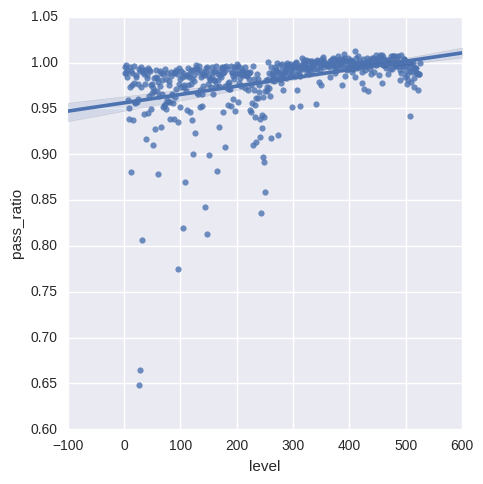

In [12]:
lmplot('level','pass_ratio',pass_ration_per_lvl,sharex=False,sharey=False)

### Можно заметить, что чем больше попыток игроку приходится препринимать, чтобы пройти игру, тем вероятнее он не пройдёт этот уровень. И как следствие перестанен играть.

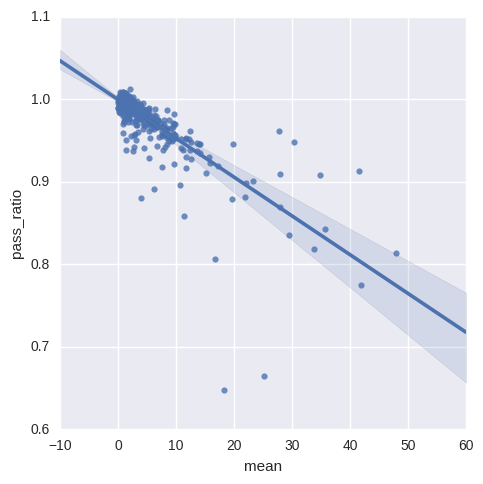

In [13]:
lmplot('mean','pass_ratio',tries_per_level,sharex=False,sharey=False)